# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [6]:
import numpy as np
import os
from skimage.transform import resize
from skimage.io import imread
import datetime
from skimage import transform as sktf
import random as rn
import tensorflow as tf
from keras.layers import Dropout, TimeDistributed, CuDNNLSTM, Dense
from keras.layers import Flatten
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import regularizers

np.random.seed(30)
rn.seed(30)
tf.random.set_seed(30)

In [7]:
os.environ["HD5_USE_FILE_LOCKING"]="FALSE"

In [8]:
train_doc = np.random.permutation(open('/content/drive/MyDrive/Project_data/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/drive/MyDrive/Project_data/Project_data/val.csv').readlines())

In [9]:
batch_size = 32 #experiment with the batch size 
HEIGHT_DIMENSION=100 
WIDTH_DIMENSION=100
INPUT_SIZE_IN_BATCH=15
INPUT_PER_FOLDER=30
y=HEIGHT_DIMENSION
z=WIDTH_DIMENSION

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [10]:
def cropAndResize(imag,HEIGHT_DIMENSION,WIDTH_DIMENSION):
    #crop the images and resize them. Note that the images are of 2 different shape 
    #and the conv3D will throw error if the inputs in a batch have different shapes
    # CROPPING (making aspect ratio same)
    if abs(imag.shape[0]-imag.shape[1])%2==0 and imag.shape[0]!=imag.shape[1]:
        dimension_diff=abs(imag.shape[0]-imag.shape[1])
        cropping_ratio=dimension_diff//2
        if imag.shape[0]>imag.shape[1]:
            imag=imag[cropping_ratio:imag.shape[0]-cropping_ratio,:,:]
        elif imag.shape[0]<imag.shape[1]:
            imag=imag[:,cropping_ratio:imag.shape[1]-cropping_ratio,:]
                    
    # RESIZING
    if imag.shape[0]>HEIGHT_DIMENSION or imag.shape[1]>WIDTH_DIMENSION:
        imag=resize(imag,(HEIGHT_DIMENSION,WIDTH_DIMENSION))
        
    return imag

In [11]:
def normalize(imag):    
    return (imag[:,:,0]-imag[:,:,0].mean())/imag[:,:,0].std(), (imag[:,:,1]-imag[:,:,1].mean())/imag[:,:,1].std(), (imag[:,:,2]-imag[:,:,2].mean())/imag[:,:,2].std()


In [12]:
def generator(source_path, folder_list, batch_size):
    print("Inside generator")
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    NUM_FOLDERS=len(folder_list)
    num_batches = NUM_FOLDERS//batch_size
    remaining_batch_size=NUM_FOLDERS%batch_size
    while True:        
        t = np.random.permutation(folder_list)                
        for batch in range(num_batches): # we iteratINPUT_SIZE_IN_BATCHe,INPUT_SIZE_IN_BATCH over the number of batches
            batch_data = np.zeros((batch_size,INPUT_SIZE_IN_BATCH,y,z,3))
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            mandatory = [0,1,28,29]
            random_list_1 = rn.sample(range(2,28),INPUT_SIZE_IN_BATCH - 4)
            random_list_1.extend(mandatory)
            random_list_1.sort()
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'//'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(random_list_1): #  Iterate iver the frames/images of a folder to read them in
                    imag = imread(source_path+'//'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'//'+imgs[item]).astype(np.float32)
                    imag = cropAndResize(imag,HEIGHT_DIMENSION,WIDTH_DIMENSION)
                    #NORMALIZING   
                    batch_data[folder,idx,:,:,0], batch_data[folder,idx,:,:,1], batch_data[folder,idx,:,:,2] = normalize(imag)                            
                                
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1                
                               
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        
        for batch in range(num_batches,num_batches+1): # we iterate over the number of batches
            rem_batch_data = np.zeros((remaining_batch_size*2,INPUT_SIZE_IN_BATCH,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            rem_batch_labels = np.zeros((remaining_batch_size*2,5)) # batch_labels is the one hot representation of the output
            mandatory = [0,1,28,29]
            random_list_1 = rn.sample(range(2,28),INPUT_SIZE_IN_BATCH - 4)
            random_list_1.extend(mandatory)
            random_list_1.sort()
            for folder in range(remaining_batch_size): # iterate over the batch_size
                print(source_path+'//'+ t[folder + (batch*batch_size)].split(';')[0])
                imgs = os.listdir(source_path+'//'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(random_list_1): #  Iterate iver the frames/images of a folder to read them in
                    imag = imread(source_path+'//'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'//'+imgs[item]).astype(np.float32)
                    imag = cropAndResize(imag,HEIGHT_DIMENSION,WIDTH_DIMENSION)
                    #NORMALIZING   
                    rem_batch_data[folder,idx,:,:,0], rem_batch_data[folder,idx,:,:,1], rem_batch_data[folder,idx,:,:,2] = normalize(imag)
                                
                rem_batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                
        yield rem_batch_data, rem_batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

In [13]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/drive/MyDrive/Project_data/Project_data/train'
val_path = '/content/drive/MyDrive/Project_data/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [14]:
base_model = VGG16(include_top=False, weights='imagenet',input_shape=(WIDTH_DIMENSION, HEIGHT_DIMENSION,3))
x = base_model.output
x = Flatten()(x)

for layer in base_model.layers:
    layer.trainable = False

model = Model(inputs=base_model.input, outputs=x)

fin_model = Sequential()
fin_model.add(TimeDistributed(model, input_shape=(INPUT_SIZE_IN_BATCH,WIDTH_DIMENSION,HEIGHT_DIMENSION,3)))
fin_model.add(CuDNNLSTM(64,return_sequences=False))
fin_model.add(Dropout(0.5))
fin_model.add(Dense(5, activation='softmax'))

58889256/58889256 [==============================] - 0s 0us/step


Now that you have written the model, the next step is to compile the model. When you print the summary of the model, you'll see the total number of parameters you have to train.

In [15]:
optimiser = Adam(lr=0.001)
fin_model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (fin_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 15, 4608)         14714688  
 ibuted)                                                         
                                                                 
 cu_dnnlstm (CuDNNLSTM)      (None, 64)                1196544   
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 5)                 325       
                                                                 
Total params: 15,911,557
Trainable params: 1,196,869
Non-trainable params: 14,714,688
_________________________________________________________________
None


/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Let us create the train_generator and the val_generator which will be used in .fit_generator.

In [16]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [17]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'hgr_sgd.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0.000001) # write the REducelronplateau code here
ES = EarlyStopping(monitor='val_categorical_accuracy', min_delta=0, patience=10, verbose=1, mode='auto', baseline=None, restore_best_weights=True)
callbacks_list = [checkpoint,LR,ES]

The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make.

In [18]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [19]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [20]:
fin_model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=50, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

<ipython-input-20-a0d13d41ea2e>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  fin_model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=50, verbose=1,


Inside generator
Source path =  /content/drive/MyDrive/Project_data/Project_data/train ; batch size = 32
Epoch 1/50
20/21 [===========================>..] - ETA: 1:36 - loss: 1.6183 - categorical_accuracy: 0.2828/content/drive/MyDrive/Project_data/Project_data/train//WIN_20180926_17_16_10_Pro_Left_Swipe_new
/content/drive/MyDrive/Project_data/Project_data/train//WIN_20180907_16_02_21_Pro_Left Swipe_new_Left Swipe_new
/content/drive/MyDrive/Project_data/Project_data/train//WIN_20180926_17_45_23_Pro_Thumbs_Down_new
/content/drive/MyDrive/Project_data/Project_data/train//WIN_20180926_17_51_06_Pro_Stop_new
/content/drive/MyDrive/Project_data/Project_data/train//WIN_20180926_17_23_38_Pro_Thumbs_Down_new
/content/drive/MyDrive/Project_data/Project_data/train//WIN_20180925_17_52_20_Pro_Left_Swipe_new
/content/drive/MyDrive/Project_data/Project_data/train//WIN_20180925_17_35_39_Pro_Left_Swipe_new
/content/drive/MyDrive/Project_data/Project_data/train//WIN_20180925_18_11_52_Pro_Right_Swipe_new


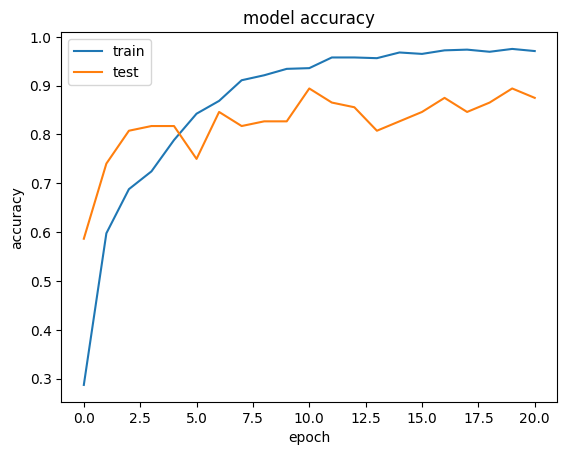

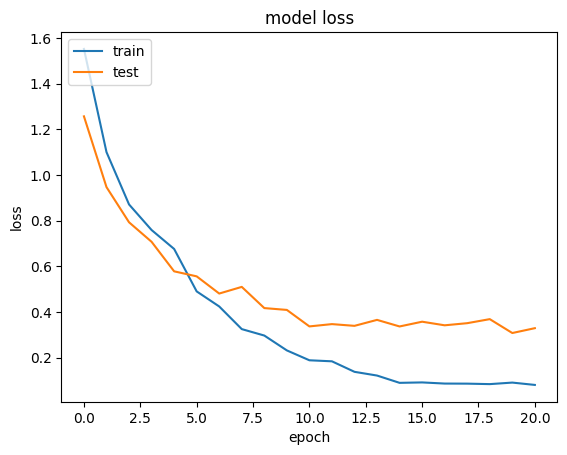

In [21]:
import matplotlib.pyplot as plt
history = fin_model.history.__dict__['history']
plt.plot(history['categorical_accuracy'])
plt.plot(history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()